# **Momento de Retroalimentación: Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)**

Zaide Islas Montiel A01751580

13/nov/23



#Introducción

*Planteamiento del problema que se busca resolver, así como su relevancia.*

El arroz, que es uno de los productos de grano más producidos en todo el mundo, tiene muchas variedades genéticas. Estas variedades se diferencian entre sí por algunas de sus características. Suelen ser características como la textura, la forma y el color. Con estas características que distinguen las variedades de arroz, es posible clasificar y evaluar la calidad de las semillas. En este estudio se utilizaron los arroces Arborio, Basmati, Ipsala, Jazmín y Karacadag, que son cinco variedades distintas de arroz que suelen cultivarse en Turquía. El conjunto de datos incluye un total de 75.000 imágenes de granos, 15.000 de cada una de estas variedades.

Debido a la cantidad de imágenes que componen el dataset, el objetivo es aplicar *Transfer learning* para realizar un modelo de clasificación de variedades de arroz. El modelo aplicado puede tener gran relevancia en la agricultura y la industria alimentaria.

1. Identificación precisa de variedades: Cada variedad de arroz puede tener diferentes características, como sabor, textura y valor nutricional, por lo que un modelo de clasificación de imágenes puede ayudar a determinar con precisión la variedad cultivada.

2. Aumento de la eficiencia en la producción: Los agricultores pueden beneficiarse de un modelo de clasificación que les permita verificar la variedad de arroz que están cultivando, lo cual puede ayudarles a tomar decisiones sobre el manejo y la comercialización de su cultivo de manera más efectiva.

3. Control de calidad: La industria alimentaria también se beneficia de la capacidad de clasificar las variedades de arroz con precisión. Pueden garantizar la calidad y la consistencia de sus productos al utilizar la variedad de arroz adecuada en sus procesos de producción.

4. Investigación y desarrollo: Los científicos e investigadores pueden utilizar un modelo de clasificación de arroz para estudiar y comprender mejor las variedades de arroz y sus características específicas, lo cual puede contribuir a la mejora de las variedades de arroz y a la selección de las variedades más adecuadas para diferentes condiciones de crecimiento y usos.

5. Reducción de errores humanos: Los modelos de clasificación de imágenes pueden ser más precisos y consistentes que la clasificación manual realizada por personas, lo que reduce la posibilidad de errores humanos en la identificación de las variedades de arroz.

6. Aplicaciones en la cadena de suministro: Un modelo de clasificación de variedades de arroz basado en imágenes puede ser útil en la cadena de suministro de arroz, desde la cosecha hasta la distribución, para asegurar que se cumplan los estándares de calidad y autenticidad.



#Datos

*Análisis y preprocesamiento del dataset empleado, así como separación en conjuntos de entrenamiento y prueba.*


El dataset consta de 75,000 imágenes, incluidas 15,000 piezas de 5 variedades diferentes de arroz:

*  Arborio
*  Basmati
*  Ipsala
*  Jazmín
*  Karacadag



## Librerías utilizadas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [2]:
pip install split-folders

In [3]:
import os
import cv2
import numpy as np
import pathlib
import splitfolders
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### Montar Kaggle

El conjunto de datos se encuentra en Kaggle. Al tener una gran cantidad de información, se decidió realizar la conexión a través de un API.

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [5]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 99% 217M/219M [00:11<00:00, 23.2MB/s]
100% 219M/219M [00:11<00:00, 20.6MB/s]


In [6]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

## Análisis de datos

Se usa la biblioteca `splitfolders` para dividir el conjunto de datos en conjuntos de entrenamiento, validación y prueba. El fragmento `seed=101` establece una semilla para garantizar la reproducibilidad de la división. El fragmento `ratio=(0.6, 0.2, 0.2)`: Define la proporción en la que se dividirá el conjunto de datos original. En este caso, el 60% se utilizará como conjunto de entrenamiento, el 20% como conjunto de validación y el 20% como conjunto de prueba.

In [7]:
# División del conjunto de datos en entrenamiento, validación y prueba
splitfolders.ratio(pathlib.Path("/content/Rice_Image_Dataset"), output="ricedataset", seed=101, ratio=(0.6, 0.2, 0.2))

# Carpetas de los conjuntos de entrenamiento, validación y prueba
training_dir = '/content/ricedataset/train'
validation_dir = '/content/ricedataset/val'
test_dir = '/content/ricedataset/test'

Copying files: 75000 files [00:12, 6189.28 files/s] 


El siguiente código muestra el tamaño de las imágenes, imprimiendo altura, ancho y canales, respectivamente. Se observa que el tamaño de las imágenes es de 250 x 250, asociados a 3 canales de color (RGB).

In [8]:
image = cv2.imread('/content/Rice_Image_Dataset/Ipsala/Ipsala (10007).jpg')
image.shape

(250, 250, 3)

Se define y configura un generador de datos para la aumentación durante el entrenamiento, validación y prueba de un modelo de aprendizaje profundo.

Para el entrenamiento, se reescalan los valores de píxeles de las imágenes al rango de 0 a 1 dividiendo cada valor por 255 (normalización de datos), se aplica rotaciones aleatorias a las imágenes en un rango de ±40 grados, se realiza traslaciones horizontales y verticales aleatorias en las imágenes con un rango del 20% del ancho y alto total de la imagen, se aplica deformaciones de corte aleatorias y aumentos aleatorios de zoom, se voltea horizontalmente aleatoriamente algunas imágenes ayudando a aumentar la variabilidad en el conjunto de datos, se rellena los píxeles recién creados después de una traslación o rotación utilizando los valores de píxeles cercanos.

Posterior, se utiliza el generador de datos configurado (train_datagen) para crear un generador de flujo de datos (train_generator) a partir de un directorio de entrenamiento (training_dir). Este generador se utiliza comúnmente en modelos de aprendizaje profundo para proporcionar imágenes aumentadas de manera dinámica durante el entrenamiento, lo que ayuda a mejorar la generalización del modelo. Además, se especifica que las etiquetas son categóricas.

In [9]:
# Aumentación de datos - entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generador de datos - entrenamiento
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 45000 images belonging to 5 classes.


Similar al código anterior con los datos de entrenamiento, en este caso, se configura un generador de datos para la validación. Se establece un generador de datos para la validación con configuraciones de aumentación más simples (solo reescalado en este caso) en comparación con el generador de datos de entrenamiento, ya que la aumentación completa no es necesaria durante la validación. Este generador de datos de validación se utilizará para evaluar el rendimiento del modelo en un conjunto de datos independiente durante el entrenamiento.

In [10]:
#  Aumentación de datos - validación
val_datagen = ImageDataGenerator(rescale=1./255)

# Cargar el generador de datos de validación
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 15000 images belonging to 5 classes.


Se establece un generador de datos para el conjunto de prueba, que se utilizará para evaluar el rendimiento final del modelo en un conjunto de datos que no ha visto durante el entrenamiento o la validación. El reescalado es la única forma de aumentación aplicada en este caso.

In [11]:
# Definir la aumentación de datos para la prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar el generador de datos de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

Found 15000 images belonging to 5 classes.


Se crea un DataFrame que contiene información sobre las imágenes de entrenamiento, incluyendo los nombres de archivo y las etiquetas de clase, a partir de las rutas de las imágenes en el directorio de entrenamiento.

In [12]:
# Imágenes de entrenamiento
trainimagestotal = glob.glob('/content/ricedataset/train/*/*.jpg')
print("Número de imágenes de entrenamiento: ", len(trainimagestotal))

Número de imágenes de entrenamiento:  45000


In [13]:
# DataFrame con los nombres de archivo y las etiquetas de clase
train_image_names = pd.Series(trainimagestotal)
traindf = pd.DataFrame()
traindf['Nombre de archivo'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])
traindf['ID Clase'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])
traindf.head()

,Nombre de archivo,ID Clase
0,Arborio (408).jpg,Arborio
1,Arborio (1486).jpg,Arborio
2,Arborio (14027).jpg,Arborio
3,Arborio (12084).jpg,Arborio
4,Arborio (10678).jpg,Arborio


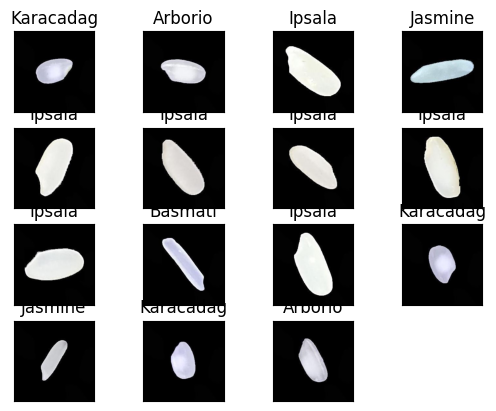

In [14]:
# Imágenes muestra
plot_df = traindf.sample(15).reset_index()

for i in range(15):
    img_name = plot_df.loc[i, 'Nombre de archivo']
    label = (plot_df.loc[i, 'ID Clase'])
    img_path = os.path.join(training_dir, label, img_name)
    plt.subplot(4, 4, i+1)
    plt.imshow(plt.imread(img_path))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])

plt.show()

#Desarrollo del modelo

*Descripción de la arquitectura empleada, entrenamiento y evaluación de resultados.*

Al utilizar *transfer learning*, se ocupa la red neuronal preentrenada *MobileNetV2* como base y agrega capas adicionales para adaptarla al conjunto de datos utilizados.

*MobileNetV2* es una red neuronal convolucional diseñada para aplicaciones móviles. Se utiliza como base para la arquitectura, y se cargan los pesos preentrenados en el conjunto de datos *ImageNet*. La capa de entrada se ajusta a imágenes de tamaño (224, 224, 3). Después de cargar *MobileNetV2*, se recorren todas sus capas y se establece `trainable = False` para que los pesos preentrenados no se actualicen durante el entrenamiento del modelo.

Se aplica *Global Average Pooling* para reducir las dimensiones espaciales y generar un único valor para cada canal, permitiendo una representación más compacta. Se agrega una capa densa con 512 neuronas y función de activación *ReLU* para aprender patrones específicos del conjunto de datos. Se aplica una capa de dropout con una tasa del 20% para evitar el sobreajuste. Finalmente, se agrega una capa densa de salida con 5 neuronas (representando las 5 clases del conjunto de datos) y una función de activación *softmax* para la clasificación multiclase.


In [15]:
mnv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mnv2.layers:
    layer.trainable = False

x = mnv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)
model = Model(inputs = mnv2.input, outputs=predictions)

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

Se compila el modelo en Keras antes de entrenarlo. En este caso, se utiliza el optimizador *Adam* con una tasa de aprendizaje de 0.001; el optimizador *Adam* es una variante del descenso de gradiente estocástico que adapta dinámicamente la tasa de aprendizaje durante el entrenamiento. Se utiliza la *entropía cruzada categórica*, que es comúnmente utilizada en problemas de clasificación con múltiples clases. Durante el entrenamiento y la evaluación del modelo, se utiliza la métrica de precisión (accuracy), que muestra la fracción de muestras correctamente clasificadas.

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Se implementaron dos técnicas de regularización:

1. **Early Stopping:** Es una técnica de detención anticipada que monitorea una métrica específica (en este caso, 'val_accuracy'). Si la métrica no mejora durante un número determinado de épocas (dado por el parámetro `patience`), el entrenamiento se detiene. Se asegura que el modelo vuelva a los pesos que tenían la mejor métrica en el conjunto de validación.

2. **Reduce Learning Rate on Plateau:** Esta técnica ajusta dinámicamente la tasa de aprendizaje durante el entrenamiento. Si la métrica monitoreada (en este caso, 'val_loss') no mejora después de un número específico de épocas (`patience`), la tasa de aprendizaje se reduce multiplicándola por un factor dado (`factor`). Esto puede ayudar a acercarse a un mínimo local de la función de pérdida y mejorar la convergencia.

Ambos callbacks se envían a la función `fit` durante el entrenamiento del modelo. Por lo tanto, durante el entrenamiento, el modelo se detendrá temprano si no hay mejoras en la precisión en el conjunto de validación, y la tasa de aprendizaje se reducirá en caso de que la pérdida en el conjunto de validación no mejore. Las técnicas son útiles para evitar el sobreajuste y mejorar la eficiencia del entrenamiento.

In [17]:
#Regularización
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 4, min_lr = 1e-6)

#Ajuste de modelo
model.fit(train_generator, epochs = 5, validation_data = val_generator, callbacks = [early_stopping, reduce_lr])

Epoch 1/5
1407/1407 [==============================] - 739s 517ms/step - loss: 0.1294 - accuracy: 0.9529 - val_loss: 0.0735 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 2/5
1407/1407 [==============================] - 734s 522ms/step - loss: 0.0926 - accuracy: 0.9678 - val_loss: 0.1774 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 3/5
1407/1407 [==============================] - 745s 529ms/step - loss: 0.0867 - accuracy: 0.9702 - val_loss: 0.1382 - val_accuracy: 0.9499 - lr: 0.0010
Epoch 4/5
1407/1407 [==============================] - 764s 543ms/step - loss: 0.0821 - accuracy: 0.9713 - val_loss: 0.0641 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 5/5
1407/1407 [==============================] - 750s 533ms/step - loss: 0.0738 - accuracy: 0.9745 - val_loss: 0.1267 - val_accuracy: 0.9524 - lr: 0.0010


La pérdida y la precisión se proporcionan tanto para el conjunto de entrenamiento como para el conjunto de validación después de cada época.
La pérdida representa qué tan lejos está la salida del modelo de la verdad conocida. La precisión es la fracción de muestras correctamente clasificadas.
En general, se busca minimizar la pérdida y maximizar la precisión.
La tasa de aprendizaje (lr) se mantiene constante en 0.001 durante todas las épocas. La precisión en el conjunto de validación aumenta en las primeras épocas, pero se observa que disminuye en la última época, lo que podría indicar un posible sobreajuste. La técnica de detención temprana (EarlyStopping) y la reducción dinámica de la tasa de aprendizaje (ReduceLROnPlateau) se están utilizando para mejorar el rendimiento del modelo.

#Ajuste del modelo

Ajuste de hiperparámetros/cambios en arquitectura para mejorar resultados previos.


El modelo MobileNetV2 contiene 154 capas.

In [18]:
len(mnv2.layers)

154

A partir de aquí, se realiza un ajuste al modelo previo, congelando las capas iniciales y permitiendo que solo las capas posteriores se ajusten durante el entrenamiento. En este caso, se están congelando las primeras 130 capas y permitiendo que las capas a partir de la posición 130 se ajusten durante el entrenamiento.

Al congelar las capas iniciales, se retienen los conocimientos aprendidos en tareas anteriores, y solo se ajustan las capas finales para adaptarse a la tarea específica del nuevo conjunto de datos. Esto puede ayudar a mejorar el rendimiento y acelerar el proceso de entrenamiento.

In [19]:
for layer in mnv2.layers[:130]:
    layer.trainable = False

Se personaliza el optimizador del modelo con una tasa de aprendizaje específica y luego compila el modelo con ese optimizador personalizado, una función de pérdida y una métrica de precisión.

In [20]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Se realiza un entrenamiento eficiente del modelo, deteniéndolo tempranamente si no se observa mejora en la métrica de precisión en el conjunto de validación y ajustando dinámicamente la tasa de aprendizaje para mejorar la convergencia. La variable history almacenará información sobre el progreso del entrenamiento, como las pérdidas y las métricas en cada época.

In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)
history = model.fit(train_generator, epochs = 3, validation_data = val_generator, callbacks= [early_stopping,reduce_lr])

Epoch 1/3
1407/1407 [==============================] - 780s 551ms/step - loss: 0.0587 - accuracy: 0.9800 - val_loss: 0.0950 - val_accuracy: 0.9660 - lr: 1.0000e-05
Epoch 2/3
1407/1407 [==============================] - 760s 540ms/step - loss: 0.0572 - accuracy: 0.9809 - val_loss: 0.0921 - val_accuracy: 0.9675 - lr: 1.0000e-05
Epoch 3/3
1407/1407 [==============================] - 741s 527ms/step - loss: 0.0538 - accuracy: 0.9817 - val_loss: 0.0922 - val_accuracy: 0.9674 - lr: 1.0000e-05


## Análisis de precisión

In [23]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]

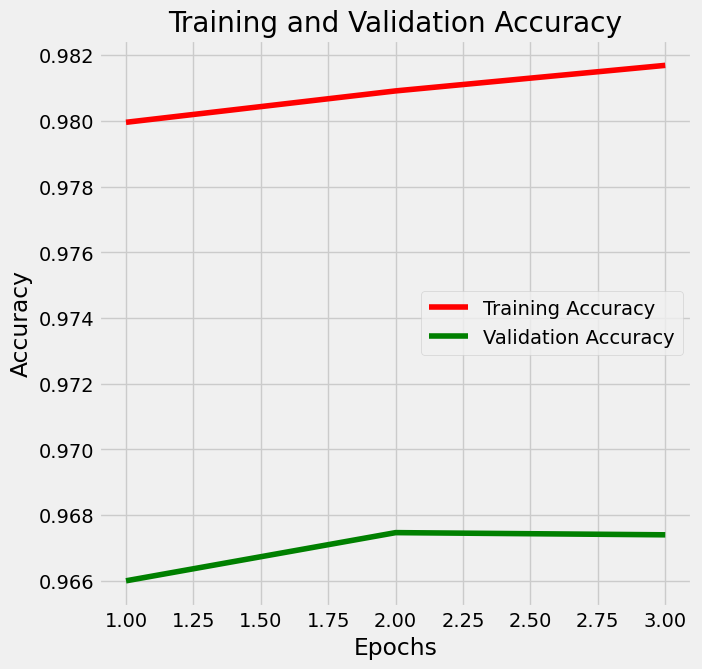

In [33]:
plt.figure(figsize= (15,7))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

**Interpretación**

La gráfica presenta la precisión del entrenamiento y la validación de un modelo. La precisión de entrenamiento es la proporción de datos de entrenamiento que el modelo clasifica correctamente. La precisión de validación es la proporción de datos de validación que el modelo clasifica correctamente.

En esta gráfica, la precisión de entrenamiento es mayor que la precisión de validación. Esto significa que el modelo es mejor para clasificar los datos de entrenamiento que los datos de validación. Esto puede deberse a que el modelo está sobreajustado a los datos de entrenamiento.

La precisión de entrenamiento aumenta a medida que el número de épocas aumenta. Esto significa que el modelo está aprendiendo a clasificar los datos de entrenamiento con mayor precisión. Sin embargo, la precisión de validación no aumenta a la misma velocidad. Esto significa que el modelo está comenzando a aprender a clasificar los datos de entrenamiento de manera demasiado específica.

En general, esta gráfica muestra que el modelo está aprendiendo a clasificar los datos de entrenamiento con mayor precisión. Sin embargo, el modelo está comenzando a sobreajustarse a los datos de entrenamiento. Esto podría conducir a un rendimiento deficiente en datos nuevos.

La precisión de entrenamiento alcanza un máximo de 0.982 en la época 2.5. La precisión de validación alcanza un máximo de 0.974 en la época 2. La diferencia entre la precisión de entrenamiento y la precisión de validación aumenta a medida que el número de épocas aumenta.

## Análsis de pérdida

In [34]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

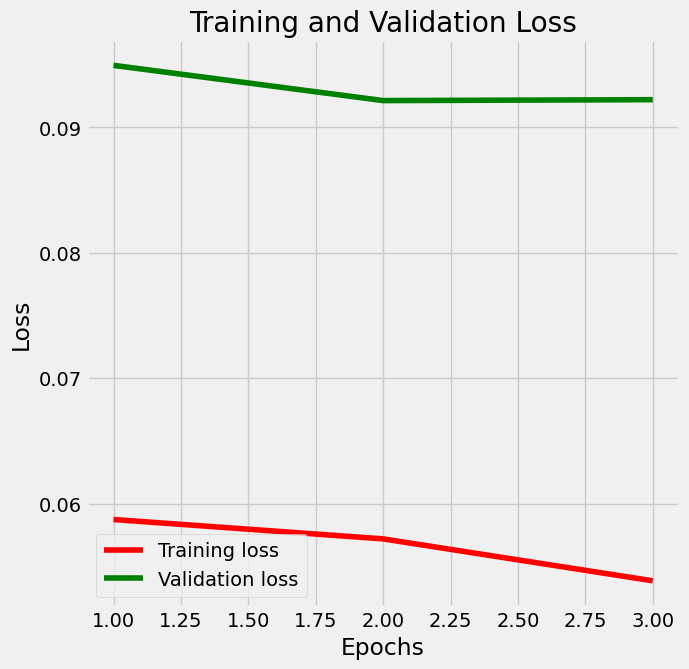

In [35]:
plt.figure(figsize= (15,7))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

**Interpretación**


La gráfica muestra la pérdida de entrenamiento y la pérdida de validación del modelo. La pérdida es una medida de la precisión con la que el modelo predice los datos.

En esta gráfica, la pérdida de entrenamiento disminuye a medida que el número de épocas aumenta. Esto significa que el modelo está aprendiendo a predecir los datos de entrenamiento con mayor precisión. Sin embargo, la pérdida de validación no disminuye a la misma velocidad. Esto significa que el modelo está comenzando a aprender a predecir los datos de entrenamiento de manera demasiado específica.

En general, esta gráfica muestra que el modelo está aprendiendo a predecir los datos de entrenamiento con mayor precisión. Sin embargo, el modelo está comenzando a sobreajustarse a los datos de entrenamiento. Esto podría conducir a un rendimiento deficiente en datos nuevos.

La pérdida de entrenamiento alcanza un mínimo de 0.062 en la época 2.5. La pérdida de validación alcanza un mínimo de 0.071 en la época 2. La diferencia entre la pérdida de entrenamiento y la pérdida de validación aumenta a medida que el número de épocas aumenta.


#Resultados

Evaluación de modelo final con datos de prueba.

In [37]:
predicciones = model.predict(test_generator)
loss, accuracy = model.evaluate(test_generator)
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

469/469 [==============================] - 61s 130ms/step - loss: 0.0950 - accuracy: 0.9665
Test loss: 0.0950, accuracy: 0.9665


La pérdida en el conjunto de prueba es de 0.0950, lo cual indica qué tan bien el modelo se ajusta a los datos del conjunto de prueba. Valores más bajos de pérdida son deseables.

La precisión en el conjunto de prueba es de 0.9665 (o 96.65%), lo cual indica la fracción de muestras correctamente clasificadas por el modelo en el conjunto de prueba. Una precisión alta es deseable.

Estos resultados sugieren que el modelo tiene un rendimiento bastante bueno en el conjunto de prueba, con una baja pérdida y una alta precisión.

#Conclusiones

*Análisis de los resultados obtenidos, identificación de posibles áreas de mejora.*


En general, el modelo entrenado ha mostrado un buen desempeño en el conjunto de prueba, con una pérdida de 0.0950 y una precisión del 96.65%. Estos resultados indican que el modelo ha aprendido eficazmente a clasificar las imágenes del conjunto de prueba.

*Ventajas*
1. Alto Nivel de Precisión: La precisión del 96.65% sugiere que el modelo está haciendo predicciones correctas en la mayoría de las muestras del conjunto de prueba.
2. Baja Pérdida: La baja pérdida de 0.0950 indica que el modelo está ajustando bien sus parámetros y minimizando la discrepancia entre las predicciones y las etiquetas reales.

*Áreas de oportunidad*
1. Análisis de Métricas Adicionales: Aunque la precisión es alta, es posible considerar analizar otras métricas de evaluación, como la recall y la precisión por clase, especialmente si el conjunto de datos tiene clases desbalanceadas.
2. Exploración de Datos Erróneos: Identificar y analizar algunas de las predicciones incorrectas podría proporcionar información valiosa sobre las debilidades del modelo y áreas de mejora específicas.
3. Ajuste de Hiperparámetros: Experimentar con diferentes configuraciones de hiperparámetros, como tasas de aprendizaje, arquitectura del modelo, y técnicas de regularización, podría mejorar aún más el rendimiento del modelo.
4. Aumento de Datos: La técnica de aumento de datos durante la fase de entrenamiento puede ayudar a mejorar la generalización del modelo y reducir el riesgo de sobreajuste.


# Fuentes consultadas


*   Koklu, M. (2021). Rice Image Dataset [Data set]. En Rice Image Dataset. https://www.muratkoklu.com/datasets/

